# Crosswind statistics

We use the boutcount approach to assess how plume dynamics change when moving away from the centreline.

In [1]:
import sys
import os
#add path to the directory containing the plumy module to PYTHONPATH
plumy_path = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir))
sys.path.append(os.path.join(plumy_path))
toplevel_path = os.path.abspath(os.path.join(os.path.pardir, os.path.pardir, os.path.pardir))

from matplotlib import cm
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.auto import  tqdm

from plumy.utils import DataSelector
from plumy.utils import HDFDataSelector
from plumy.utils import ZipFileDataSelector

<ipython-input-1-09b00fa97c4b>:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import  tqdm


In [2]:
path = os.path.join(toplevel_path,'WTD_upload')  # path to dataset
rem_dupes = True  # Drop duplicate timestamps
resample = True   # Signal resampling active
ds = DataSelector(path, drop_duplicates = rem_dupes, resample = resample, verbose = False, use_HDFcache=True)

In [ ]:
path = os.path.join(toplevel_path, 'WTD_upload.zip')
dsz = ZipFileDataSelector(path, drop_duplicates = rem_dupes, resample = resample, verbose=False, use_HDFcache=True)
ds = dsz

In [ ]:
path = os.path.join(toplevel_path, 'WTD_upload.zip_HDFcache')
dsh = HDFDataSelector(path, drop_duplicates = rem_dupes, resample = resample, verbose=False)
ds = dsh

In [3]:
from plumy.bouts import *

#### Preliminaries for nice plots

In [4]:
plt.rc('text', usetex=False)
mpl.rcParams['savefig.dpi'] = 150 # for print, go to 600
from __future__ import unicode_literals
import mpl_toolkits.axes_grid.anchored_artists as aa

<ipython-input-4-20f4f8354400>:4: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  import mpl_toolkits.axes_grid.anchored_artists as aa


In [5]:
gas = 1
voltage = 5
speed = 1
dist = 5 # using distance 5 (1.40 m from source)
trial = 'all'

print("using Gas: {}, Voltage: {}, Fan Speed: {}, Distance: {}, Trial #{}.".format(
        DataSelector.GasNames[gas], 
        DataSelector.SensorVoltages[voltage], DataSelector.AltFanSpeeds[speed], 
        DataSelector.Locs[dist],
        trial))

using Gas: Acetaldehyde_500, Voltage: 600V, Fan Speed: 1500rpm, Distance: L5, Trial #all.


In [6]:
data = dsz.select(gas,dist,voltage,speed)

## Analysing position L5, 1.40 m from the source

In [7]:
hl = 40 
smooth_std = 30.

ebcs = []
for b in tqdm(range(1,10)):
    board = "Board{}".format(b)
    ebcs.append(make_boutcounters([data], 
                         sensorname="Sensor3", 
                         boardname=board,
                         halflife=hl,
                         smooth_std=smooth_std,
                         ampthresh=None, #estimate from baseline
                         use_data_baseline=True, 
                         durthresh=0., 
                         verbose=True))

amp stats: mean: 0.000902 std: 0.00103 median: 0.000591 min: 6.39e-09 max: 0.00873
Using estimated ampthresh = 0.004
Warning encountered at distance 0 trial 0:
No bouts exceeding amplitude threshold 0.004. Largest bout is 0.00299
Warning encountered at distance 0 trial 1:
No bouts exceeding amplitude threshold 0.004. Largest bout is 0.00351
Warning encountered at distance 0 trial 8:
No bouts exceeding amplitude threshold 0.004. Largest bout is 0.00378
Warning encountered at distance 0 trial 10:
No bouts exceeding amplitude threshold 0.004. Largest bout is 0.00277
Warning encountered at distance 0 trial 13:
No bouts exceeding amplitude threshold 0.004. Largest bout is 0.00383
Warning encountered at distance 0 trial 14:
No bouts exceeding amplitude threshold 0.004. Largest bout is 0.00329
amp stats: mean: 0.000755 std: 0.000817 median: 0.000463 min: 1.37e-06 max: 0.00511
Using estimated ampthresh = 0.0032
Warning encountered at distance 0 trial 0:
No bouts exceeding amplitude threshold 0

In [8]:
ebcs_a = np.array(ebcs).squeeze()
ebcs_a.shape


(9, 20)

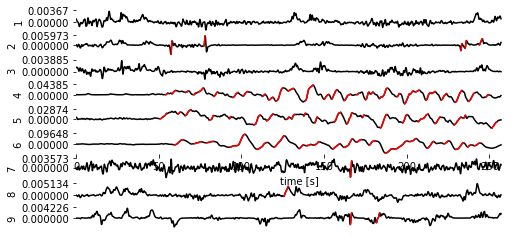

In [9]:
#plot bouts on all nine boards
f = plt.figure(figsize=(8,4))
gs = mpl.gridspec.GridSpec(9,1)
trial = 10 # the trial to show in A)
for i in range(9):
    ebc = ebcs_a[i,trial]
    ax = f.add_subplot(gs[i])
    s = ebc.smooth_time_deriv_ewma()
    p = ebc.filtered_posneg
    xaxis = [x/100. for x in range(len(s))]
    ax.plot(xaxis, s, color='k')
    if not p is None:
        for j in p.T.astype(int):
            ax.plot(np.arange(j[0], j[1])/100., s[j[0]:j[1]], color='red')
    if i ==  5:
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xlabel('time [s]')
    else:
        ax.set_xticks([])
        ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('left')
    ax.set_yticks([0., ax.get_ylim()[1]])
    ax.set_xlim(0,270)
    ax.set_ylabel(i+1)

#    ax.set_ylabel(labels[i])
    ax.set_frame_on(False)


Analysis: Not many bouts seem to appear in boards 1-3 and 7-9. Only boards 4-6 seem to be inside the plume during substantial amounts of time. The signal at board 6 seems to be even higher than on board 5 on the centreline. This might be due to plume meandering in this trial.

Text(0, 0.5, 'board')

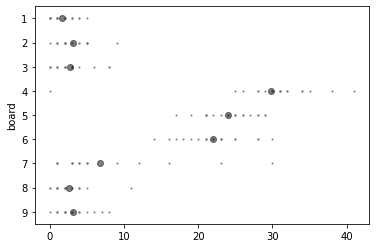

In [10]:
# plot boutcounts vs. lateral displacement for all trials
labels = ["B{}".format(i) for i in range(1,10)] #position labels
f = plt.figure()
ax = f.add_subplot(111)
boutcounts = np.zeros((9, 20))
for board in range(9):
    for trial in range(20):
        p = ebcs_a[board, trial].filtered_posneg
        if p is None:
            boutcounts[board,trial] = 0.
        else:
            boutcounts[board,trial] = p.shape[1] 
    
pl = ax.plot(boutcounts, range(8,-1,-1), ls='none', lw=0.3, marker='.',
                                ms=2., mfc='none', color='grey', zorder=1)
pl[0].set_label('indiv. trials')
ax.plot(np.mean(np.array(boutcounts), axis=1), range(8,-1,-1), color=[0.,0.,0.,0.5],
                                ls='none', marker='o', markersize=6, zorder=3, label='mean')
ax.set_ylim([-.5, 8.5])
ax.set_yticks(range(9))
ax.set_yticklabels(range(9,0,-1))
ax.set_ylabel('board')

Also here, significant numbers of bouts occur only on boards 4-6, the highest number of board 4, and board 7 showing rather high variance.

All in all, enough interesting effects to warrant a somewhat deeper inspection.

Next, let's look at how bout statistics evolve not just at 1.40 m, but over all of the wind tunnel.

In [11]:
data_all = []
for dist in tqdm(range(1,7)):
    data_all.append(dsz.select(gas,dist,voltage,speed))

In [12]:
hl = 40 
smooth_std = 30.

ebcs_all = []
for b in range(1,10):
    board = "Board{}".format(b)
    ebcs_all.append(make_boutcounters(data_all, 
                         sensorname="Sensor3", 
                         boardname=board,
                         halflife=hl,
                         smooth_std=smooth_std,
                         ampthresh=None, #estimate from baseline
                         use_data_baseline=True, 
                         durthresh=0., 
                         verbose=True))

amp stats: mean: 0.00101 std: 0.00108 median: 0.00068 min: -6.48e-09 max: 0.00873
Using estimated ampthresh = 0.00424
Warning encountered at distance 0 trial 1:
No bouts exceeding amplitude threshold 0.00424. Largest bout is 0.00348
Warning encountered at distance 0 trial 7:
No bouts exceeding amplitude threshold 0.00424. Largest bout is 0.00376
Warning encountered at distance 0 trial 15:
No bouts exceeding amplitude threshold 0.00424. Largest bout is 0.00424
Warning encountered at distance 1 trial 11:
No bouts exceeding amplitude threshold 0.00424. Largest bout is 0.00404
Warning encountered at distance 1 trial 13:
No bouts exceeding amplitude threshold 0.00424. Largest bout is 0.00416
Warning encountered at distance 1 trial 18:
No bouts exceeding amplitude threshold 0.00424. Largest bout is 0.00407
Warning encountered at distance 2 trial 12:
No bouts exceeding amplitude threshold 0.00424. Largest bout is 0.00399
Warning encountered at distance 2 trial 13:
No bouts exceeding amplitude

In [13]:
ebcs_all_a = np.array(ebcs_all)
ebcs_all_a.shape


(9, 6, 20)

The array's dimensions refer to board, distance, trial.

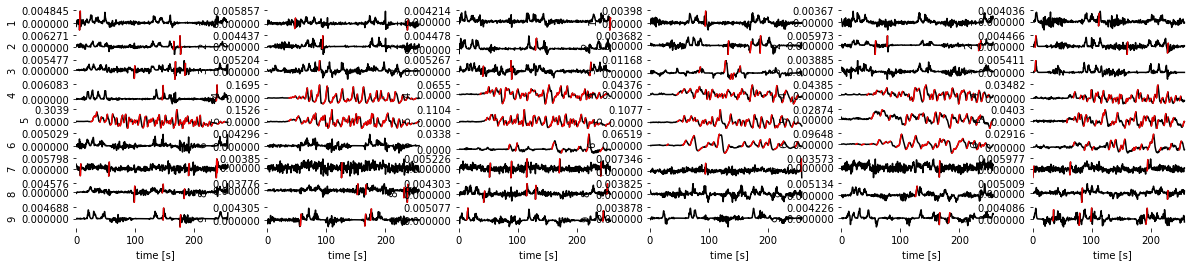

In [14]:
#plot bouts on all nine boards, for all 6 distances
f = plt.figure(figsize=(20,4))
gs = mpl.gridspec.GridSpec(9,6)
trial = 10 # the trial to show in A)
for dist in range(6):
    for board in range(9):
        ebc = ebcs_all_a[board,dist,trial]
        ax = f.add_subplot(gs[board, dist])
        s = ebc.smooth_time_deriv_ewma()
        p = ebc.filtered_posneg
        xaxis = [x/100. for x in range(len(s))]
        ax.plot(xaxis, s, color='k')
        if not p is None:
            for j in p.T.astype(int):
                ax.plot(np.arange(j[0], j[1])/100., s[j[0]:j[1]], color='red')
        if board ==  8:
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xlabel('time [s]')
        else:
            ax.set_xticks([])
            ax.xaxis.set_ticks_position('none')
        ax.yaxis.set_ticks_position('left')
        ax.set_yticks([0., ax.get_ylim()[1]])
        ax.set_xlim(0,270)
        ax.set_ylabel(board+1)

    #    ax.set_ylabel(labels[i])
        ax.set_frame_on(False)


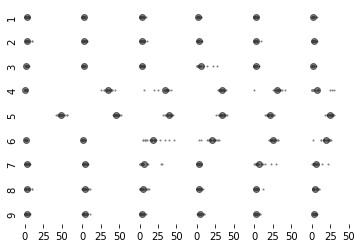

In [15]:
# plot boutcounts vs. lateral displacement for all trials
labels = ["B{}".format(i) for i in range(1,10)] #position labels
gs = mpl.gridspec.GridSpec(9,6)
f = plt.figure()
boutcounts = np.zeros((9, 6, 20))
for dist in range(6):
    for board in range(9):
        for trial in range(20):
            p = ebcs_all_a[board, dist, trial].filtered_posneg
            if p is None:
                boutcounts[board, dist, trial] = 0.
            else:
                boutcounts[board, dist, trial] = p.shape[1] 
        ax = f.add_subplot(gs[board,dist])

        bc = boutcounts[board,dist],
        pl = ax.plot(bc, np.zeros_like(bc), ls='none', lw=0.3, marker='.', 
                                        ms=2., mfc='none', color='grey', zorder=1)
#        pl[0].set_label('indiv. trials')
        ax.plot(np.mean(np.array(bc), axis=1), 0., color=[0.,0.,0.,0.5], 
                                        ls='none', marker='o', markersize=6, zorder=3, label='mean')
        ax.set_ylim([-.5, .5])
        ax.set_yticks([])
        ax.set_xlim(-5,60)
        ax.set_frame_on(False)
        ax.xaxis.set_ticks_position('bottom')
        ax.yaxis.set_ticks_position('left')
        if board != 8:
            ax.set_xticks([])
        else:
            ax.set_xticks([0,25,50])
        if dist == 0:
            ax.set_ylabel(board+1)
            


how does Variance and variance over mean look?

In [16]:
# plot mean and variance of boutcounts vs. lateral displacement for all trials
boutcounts = np.zeros((9, 6, 20))
for dist in range(6):
    for board in range(9):
        for trial in range(20):
            p = ebcs_all_a[board, dist, trial].filtered_posneg
            if p is None:
                boutcounts[board, dist, trial] = 0.
            else:
                boutcounts[board, dist, trial] = p.shape[1] 


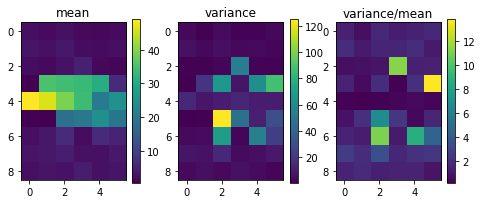

In [17]:
f = plt.figure(figsize=(8,3))
ax = f.add_subplot(1,3,1)
img = ax.imshow(np.mean(boutcounts, axis=2), interpolation='nearest')
ax.set_title("mean")
plt.colorbar(img)
ax = f.add_subplot(1,3,2)
img = ax.imshow(np.var(boutcounts, axis=2), interpolation='nearest')
ax.set_title("variance")
plt.colorbar(img)
ax = f.add_subplot(1,3,3)
img = ax.imshow(np.var(boutcounts, axis=2)/np.mean(boutcounts, axis=2), interpolation='nearest')
ax.set_title("variance/mean")
plt.colorbar(img)


Interesting: only along the midline variance/mean is rather low, if we depart from the midline variance/mean is rising. But we should find a clearer way of illustrating this than the image matrix. Try line plots:

Text(0, 0.3, 'C)')

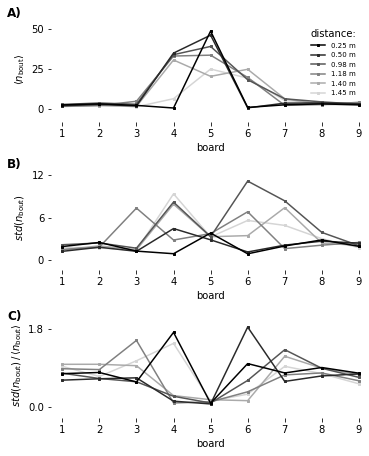

In [24]:
f = plt.figure(figsize=(5,7))
gs = mpl.gridspec.GridSpec(3,1, hspace=0.75, left=0.15, right=0.98)
ax_m = f.add_subplot(gs[0])
ax_v = f.add_subplot(gs[1])
ax_vm = f.add_subplot(gs[2])
colors = cm.gray(np.linspace(0,1,7))
labels = ['0.25 m', '0.50 m', '0.98 m', '1.18 m', '1.40 m', '1.45 m']
for d in range(6):
    ax_m.plot(np.mean(boutcounts[:,d,:], axis=1), 
              color=colors[d], linestyle='-', marker='s', mec=colors[d], markersize=2, label=labels[d], zorder=5-d)
    ax_v.plot(np.std(boutcounts[:,d,:], axis=1), 
              color=colors[d], linestyle='-', marker='s', mec=colors[d], markersize=2, label=labels[d], zorder=5-d)
    ax_vm.plot(np.std(boutcounts[:,d,:], axis=1)/np.mean(boutcounts[:,d,:], axis=1), 
               color=colors[d], linestyle='-', marker='s', mec=colors[d], markersize=2, label=labels[d], zorder=5-d)
ax_m.legend(frameon=False, fontsize=7, title='distance:', loc=(0.825,0.15))
for ax in [ax_m, ax_v, ax_vm]:
    ax.set_frame_on(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-.03, 8.03)
    ax.set_xticks(range(9))
    ax.set_xticklabels(range(1,10))
    ax.set_xlabel('board')
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    maxy = ax.get_ylim()[1]
    ax.set_yticks([0, maxy//2, maxy])
ax_m.set_ylabel(r'$\langle n_{\sf{bout}}\rangle$')
ax_m.set_yticks([0, 25, 50])
ax_v.set_ylabel(r'$std(n_{\sf{bout}})$')
ax_v.set_yticks([0, 6, 12])
ax_vm.set_ylabel(r'$std(n_{\sf{bout}})\,/\,\langle n_{\sf{bout}}\rangle$')
ax_vm.set_yticks([0, 1.8])
f.text(0,0.9,'A)', fontsize=12, fontweight='bold')
f.text(0,0.6,'B)', fontsize=12, fontweight='bold')
f.text(0,0.3,'C)', fontsize=12, fontweight='bold')

In [25]:
f.savefig("Figures/Fig. 10 - Crosswind statistics.png", dpi=600)

####Figure Caption: 
Bout count statistics perpendicular to the downwind direction; Acetaldehyde 500 ppm, heater voltage 6 V, fan speed 1500rpm, A) Average bout counts $\langle n_{\sf{bout}}\rangle$ over 20 repetitions. Board 5 is the centre board. Distances are color-coded as indicated in the legend. B) Variance of bout counts $var(n_{\sf{bout}})$ over 20 repetitions. C) Variance over mean bout counts $var(n_{\sf{bout}})\,/\,\langle n_{\sf{bout}}\rangle$.

####Interpretation:

Fig. XA shows that in close proximity to the source, bouts occurred basically only on the centreline board (Board no. 
5). Further downwind, bouts were more frequent also in the positions adjacent to the centreline. Hardly any bouts were detected on the three outermost boards on either side, indicating that the region of plume dispersal was limited to a region central to the wind tunnel (See also Vergara et al, 2013). Interestingly, the variance of bout counts across repetitions was low along the centreline (Fig. XB), even when normalising for average bout count (Fig. XC). In contrast, the variance of the bout counts increased drastically when detectors were placed off the centreline. This is consistent with previous observations in the open field (CITATION) and in wind tunnels (CITATION), according to which the intermittency of gas encounters increases when moving farther away from the centreline of the plume. 

#### Discussion:

While information about source distance is encoded in the first moment of bout count statistics (i.e., the average bout count), the second moment (i.e., variance) encodes information about the lateral position to the centreline (Fig. XXX TODO). A putative navigational strategy thus may analyse both moments to assist an estimation of the two-dimensional position of an agent downwind of a gas source. More specifically, during exploration of the plume the agent could use the change in average bout counts (together with the wind direction) to estimate whether it approaches the source (i.e., mean bout count increases), while it could use the change in variance of bout couts to estimate whether it navigates towards the centreline of the plume (variance is decreasing), or away from it (variance is increasing). The viability of such a bout count-based navigational strategy could potentially be explored in future experiments that combine simulations of gas plume dispersal with simulated MOX gas sensors on a robotic agent in a virtual environment. The feasibility of such simulations has already been demonstrated (Khaliq et al. 2015). 

--- Re: biological significance: Park et al. Refer to the "virtual mouse" in HBP Neurorobotics to explore whether such a strategy could also be used in mice. 


## Inter-bout interval statistics
Mean and variance of bout counts are fine, but the same information might be obtained via inter-bout interval statistics. The mean bout count can be substituted by the mean inter-bout interval (which should approximately relate to 1/mean count), the per-trial variance of counts could be replaced by the variance of inter-bout intervals.

First we have to make inter-bout interval stats.

In [26]:
# Inter-bout Intervals, IBI
IBI = np.zeros((9, 6, 20), dtype=object)
for dist in range(6):
    for board in range(9):
        for trial in range(20):
            p = ebcs_all_a[board, dist, trial].filtered_posneg
            if (p is None) or (p.shape[1] <=1):
                IBI[board, dist, trial] = np.array([np.nan])
            else:
                s = p[0,:] #bout start
                e = p[1,:] #bout end
                IBI[board, dist, trial] = 0.01 * np.array([e[i] - s[i-1] for i in range(1,len(e))])

mean_IBI = np.zeros((9,6,20))
std_IBI = np.zeros((9,6,20))
for dist in range(6):
    for board in range(9):
        for trial in range(20):
            mean_IBI[board,dist,trial] = 1./np.nanmean(IBI[board,dist,trial])
            std_IBI[board,dist,trial] = np.nanstd(IBI[board,dist,trial])

<ipython-input-26-cd26218234fe>:19: RuntimeWarning: Mean of empty slice
  mean_IBI[board,dist,trial] = 1./np.nanmean(IBI[board,dist,trial])
/home/sam/anaconda3/envs/exploiting_plume/lib/python3.9/site-packages/numpy/lib/nanfunctions.py:1664: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Text(0, 0.3, 'C)')

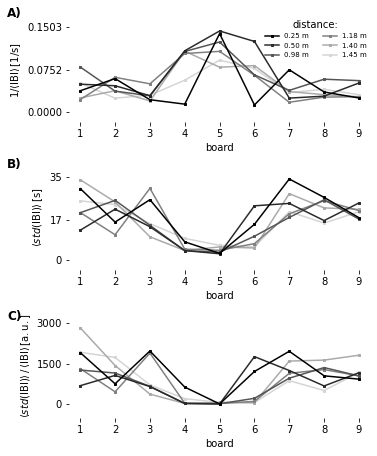

In [28]:
f = plt.figure(figsize=(5,7))
gs = mpl.gridspec.GridSpec(3,1, hspace=0.75, left=0.2, right=0.98)
ax_m = f.add_subplot(gs[0])
ax_v = f.add_subplot(gs[1])
ax_vm = f.add_subplot(gs[2])
colors = cm.gray(np.linspace(0,1,7))
labels = ['0.25 m', '0.50 m', '0.98 m', '1.18 m', '1.40 m', '1.45 m']
for d in range(6):
    ax_m.plot(np.nanmean(mean_IBI[:,d,:], axis=1), 
              color=colors[d], linestyle='-', marker='s', mec=colors[d], markersize=2, label=labels[d], zorder=5-d)
    ax_v.plot(np.nanmean(std_IBI[:,d,:], axis=1), 
              color=colors[d], linestyle='-', marker='s', mec=colors[d], markersize=2, label=labels[d], zorder=5-d)
    ax_vm.plot(np.nanmean(std_IBI[:,d,:]/mean_IBI[:,d,:], axis=1), 
               color=colors[d], linestyle='-', marker='s', mec=colors[d], markersize=2, label=labels[d], zorder=5-d)
ax_m.legend(frameon=False, fontsize=7, title='distance:', loc=(0.65,0.6), ncol=2)
for ax in [ax_m, ax_v, ax_vm]:
    ax.set_frame_on(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left')
    ax.set_xlim(-.03, 8.03)
    ax.set_xticks(range(9))
    ax.set_xticklabels(range(1,10))
    ax.set_xlabel('board')
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    maxy = ax.get_ylim()[1]
    if ax == ax_m:
        ax.set_yticks([0, maxy/2., maxy])
    else:
        ax.set_yticks([0, maxy//2, maxy])
ax_m.set_ylabel(r'$1/\langle\sf{IBI}\rangle\,\sf{[1/s]}$ ')
ax_v.set_ylabel(r'$\langle std\left(\sf{IBI}\right)\rangle\,\sf{[s]}$')
ax_v.set_yticks([0, 17, 35])
ax_vm.set_ylabel(r'$\langle std\left(\sf{IBI}\right)\rangle\,/\,\langle \sf{IBI} \rangle\,\sf{[a.u.]}$')
ax_vm.set_yticks([0, 1500, 3000])
f.text(0,0.9,'A)', fontsize=12, fontweight='bold')
f.text(0,0.6,'B)', fontsize=12, fontweight='bold')
f.text(0,0.3,'C)', fontsize=12, fontweight='bold')

In [29]:
f.savefig('Figures/Fig S6 - Crosswind statistics - IBI.png', dpi=600)